# ECMWF ERA5 data issues review


## Technical questions
1. Minimum temperature at time 10:00 (and any other forecast step != 1) is given as minimum over period 09:00 - 09:59 instead of 09:01 - 10:00, as one would expect from documentation `HRES: the minimum or maximum values are in the hour ending at the forecast step`, https://confluence.ecmwf.int/display/CKB/ERA5+data+documentation#ERA5datadocumentation-Minimum/maximumsincethepreviouspostprocessing
2. Minimum temperature at 2t forecast step 12 and mn2t step 1 is not understandable. It is not minimum over previous or next hour.

## Logical issues?
1. CDS allows data to be downloaded at 0.25 degree grid resolution, while model native resolution is 0.28125 degrees. From the ECMWF API, however, the data was given at native resolution (in GRIB files). There is an explanation about the possible reason here https://confluence.ecmwf.int/display/CKB/ERA5%3A+What+is+the+spatial+reference , which kind of says that GRIB1 is not capable of 0.28125 degrees regular lat/lon coordinates (only supports three decimal places). But there is also a mention `However, the ECMWF interpolation software does not conserve area integrals, ...`, which makes one wonder if data interpolated to 0.25 degree grid actually is area conservative or not? Also, modern grib reading software (pygrib, java CDM) do not have problem in reading the native grid grib files and returning the correct 0.28125 resolution, so interpolation of data before giving to users, seems unnecessary.
2. CDS only allows download of data for either forecast or analysis components. While it is perfectly understandable, that for parameters like the 2m temperature, analysis is closer to the reality/observations than 2m temperature forecast (giving new forecast made every 12 hours), it also means that 2m minimum temperature is not really useable together with 2m temperature, because the forecasted minimum can actually be higher than analysed hourly temperature, and it is not clear what is the use case for such a variable.

## Analysis
First, we analyse 2m temperature forecast vs minimum 2m temperature forecast, showing the time step difference and problem with new analysis cycle. 
Then, we show that forecasted mn2t can be higher than analysed 2t over large areas, questioning how they can be used together. 

## Data
We get sample data via ECMWF API (soon to be closed). 

### Requests
`{'type': 'fc', 'levtype': 'sfc', 'step': '1/2/3/4/5/6/7/8/9/10/11', 'param': '167.128', 'dataset': 'era5', 'stream': 'oper', 'target': '/data.e2/ERA5_analysis/era5_167.128_2011_1_fc.grb2', 'expver': '1', 'class': 'ea', 'date': '2011-01-01/to/2011-01-31', 'time': '06:00:00/18:00:00'}`

### Location
`/data.e2/ERA5_analysis/`


In [4]:
%matplotlib notebook
import os
import boto3
import pygrib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import datetime
import pandas as pd
import types

### Data preparation
While NetCDF4 would be easier to analyse, GRIB -> NetCDF4 conversion with CDM tools gives a strange structure with 2D time variable and 1D time dimension, and may have unknown problems, so we analyse everything directly from GRIB.

In [5]:
## TODO: put and get files from the S3
## lets analyse grib directly for January 2011.
fmin = pygrib.open('/data.e2/ERA5_analysis/era5_202.128_2011_1_fc_v2.grb2')
ft2m = pygrib.open('/data.e2/ERA5_analysis/era5_167.128_2011_1_fc_v2.grb2')
ft2m_an = pygrib.open('/data.e2/ERA5_analysis/era5_167.128_2011_1_an_v1.grb2')

In [14]:
window = 2 # total steps is window * 2 + 1
max_count = ft2m_an.messages - window -7 
max_count = 12

def get_grib_time_step(in_fld):
    """
    convert grib message time to timestamp, using step. Attention when using with aggregated fields like mn2t
    """
    in_date = datetime.datetime(int(str(in_fld.date)[0:4]), int(str(in_fld.date)[4:6]), int(str(in_fld.date)[6:8]))
    in_time = datetime.timedelta(hours=in_fld.time/100)
    in_step = datetime.timedelta(hours=in_fld.step)
    return in_date + in_time + in_step

def get_diff(pre, suf, window, pre_suf_diff):
    return {tstep_diff: [
        (np.mean(pre[tstep_an].data()[0] - suf[tstep_an-pre_suf_diff+tstep_diff].data()[0]), 
         np.amin(pre[tstep_an].data()[0] - suf[tstep_an-pre_suf_diff+tstep_diff].data()[0]),
         np.sum(np.where((pre[tstep_an].data()[0] - suf[tstep_an-pre_suf_diff+tstep_diff].data()[0])<-1,1,0)),
         tstep_an, pre[tstep_an].step, suf[tstep_an-pre_suf_diff+tstep_diff].step,
            get_grib_time_step(pre[tstep_an]), get_grib_time_step(suf[tstep_an-pre_suf_diff+tstep_diff]))
            for tstep_an in range(pre_suf_diff+1+window, max_count+pre_suf_diff+1+window)]
        for tstep_diff in range(-1*window, window+1)
    }
    
## an2t_mn2t_diff -- difference between analysed 2t and forecasted mn2t. Note that analysis starts 7 hours before forecast.
## an2t_fc2t_diff -- difference between analysed 2t and forecasted 2t
## fc2t_mn2t_diff -- difference between forecasted 2t and forecasted mn2t

an2t_mn2t_diff = get_diff(ft2m_an, fmin, window, 7)
an2t_fc2t_diff = get_diff(ft2m_an, ft2m, window, 0)
fc2t_mn2t_diff = get_diff(ft2m, fmin, window, 0)

In [7]:
def get_sm(infld, diff_add=0):
    rd = {'Step diff':[], "min":[], "mean":[], "median min":[], 
          "diff > -2 mean":[], 
          "diff > -2 max":[], 
          "diff > -2 min":[]}
    for k,v in infld.items():
        atemp = np.array(v)
        date_diff1 = np.diff(atemp[:,6])
        date_diff2 = np.diff(atemp[:,7])
        date_diff3 = list(map(datetime.timedelta.total_seconds, atemp[:,7] - atemp[:,6]))
        assert np.amin(date_diff1) == np.amax(date_diff1)
        assert np.amin(date_diff2) == np.amax(date_diff2)
        assert np.isclose(float(np.mean(date_diff3)), float(k * 3600)), "{0} {1} {2} {3}".format(k, diff_add, np.mean(date_diff3), (k+diff_add)*3600)
        rd['Step diff'].append(k)
        rd['min'].append(np.amin(atemp[:,1]))
        rd['mean'].append(np.mean(atemp[:,0]))
        rd['median min'].append(np.median(atemp[:,1]))
        rd['diff > -2 mean'].append(np.mean(atemp[:,2]))
        rd['diff > -2 max'].append(np.amax(atemp[:,2]))
        rd['diff > -2 min'].append(np.amin(atemp[:,2]))
    return pd.DataFrame(rd).set_index('Step diff')

### Forecasted 2t vs mn2t
Here we show 2t-mn2t over several timesteps and several shifts between data steps. It is evident that the only case when median difference is not negative, is 1, i.e. where mn2t is taken next step from 2t. 

In [8]:
get_sm(fc2t_mn2t_diff)

,diff > -2 max,diff > -2 mean,diff > -2 min,mean,median min,min
Step diff,,,,,,
-2,86011,70540,42789,0.109860,-11.618835,-12.955847
-1,49342,35034,20713,0.105835,-9.071312,-11.095901
0,730,437,228,0.111538,-2.890373,-3.535675
1,10162,846,0,0.126054,0.000000,-7.794968
2,33047,20702,8266,0.148293,-6.806145,-11.376465


Step diff == 1 shows a case where minimum value of 2t-mn2t is mostly zero, except for the step 12 of 2t and 1 of mn2t. This can be illustrated by setting step_diff = 1 in the next graph. 

<IPython.core.display.Javascript object>


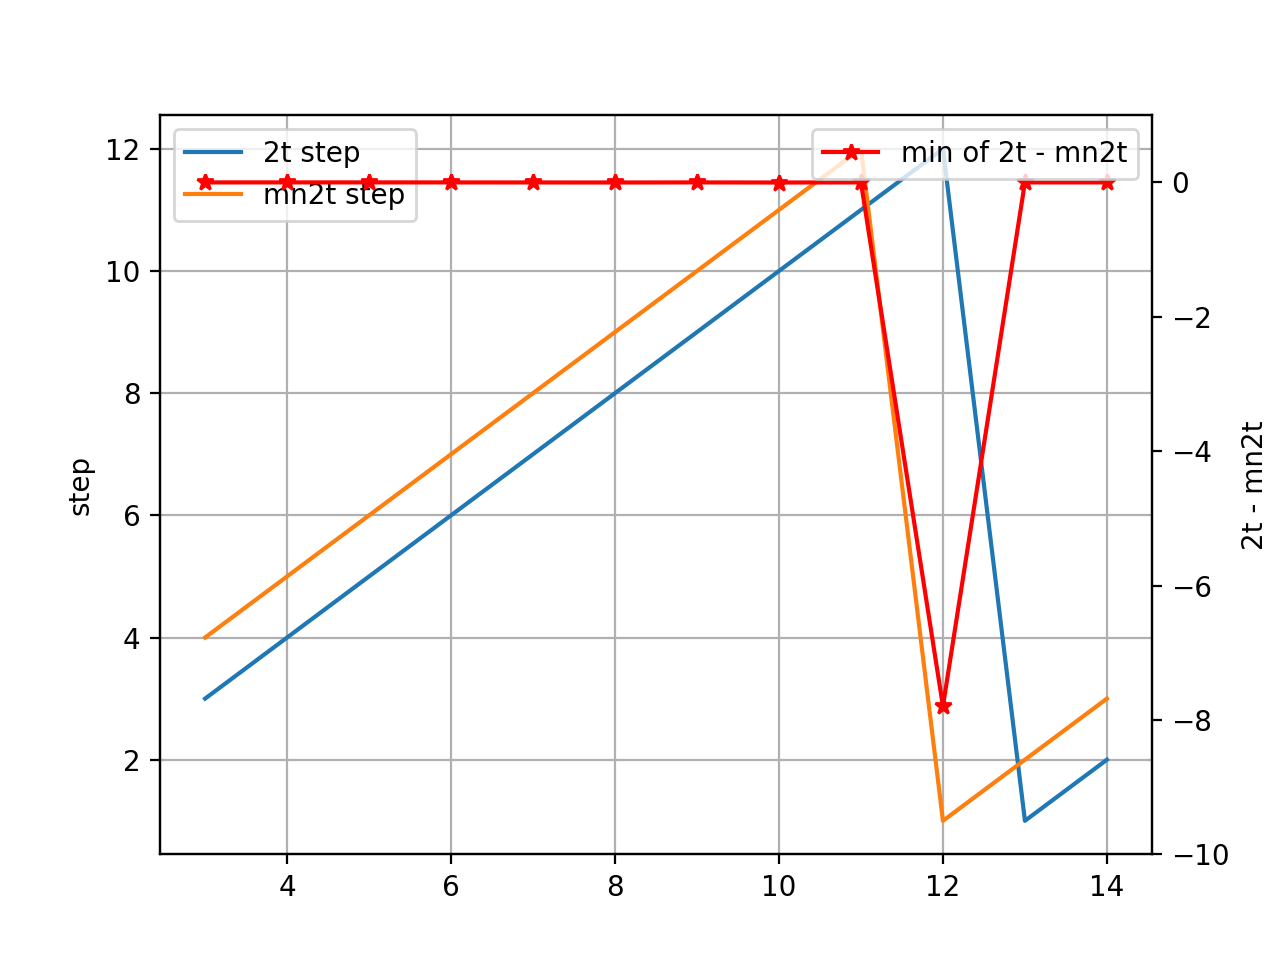

In [9]:
step_diff = 1
atemp=np.array(fc2t_mn2t_diff[step_diff])
fig, ax_1 = plt.subplots()
ax_2 = ax_1.twinx()
ax_1.plot(atemp[:,3],atemp[:,4], label='2t step')
ax_1.plot(atemp[:,3],atemp[:,5], label='mn2t step')
ax_1.set_ylabel("step")
ax_2.plot(atemp[:,3],atemp[:,1], '-*', c='r', label='min of 2t - mn2t')
ax_2.set_ylabel("2t - mn2t")
ax_2.set_ylim([-10,1])
ax_1.grid()
ax_1.legend()
ax_2.legend()
plt.show()

### Analysed 2t vs forecasted mn2t
Next, lets see what happens when we replace the forecasted 2t to possibly more "accurate", analysed 2t.

In [10]:
get_sm(an2t_mn2t_diff)

,diff > -2 max,diff > -2 mean,diff > -2 min,mean,median min,min
Step diff,,,,,,
-2,85128,68480,50617,0.274737,-11.857689,-13.321365
-1,56516,44942,36217,0.270712,-8.870117,-10.609192
0,36995,26585,21630,0.276415,-5.308685,-7.975403
1,26823,22296,17625,0.290931,-5.229584,-7.521637
2,48850,32096,25316,0.313170,-7.850163,-10.420097


Apparenlty, for any timestep, there is a large number of grid points, where minimum temperature is more than 2 degrees higher than corresponding hourly temperature. Looking at single timesteps:

<IPython.core.display.Javascript object>


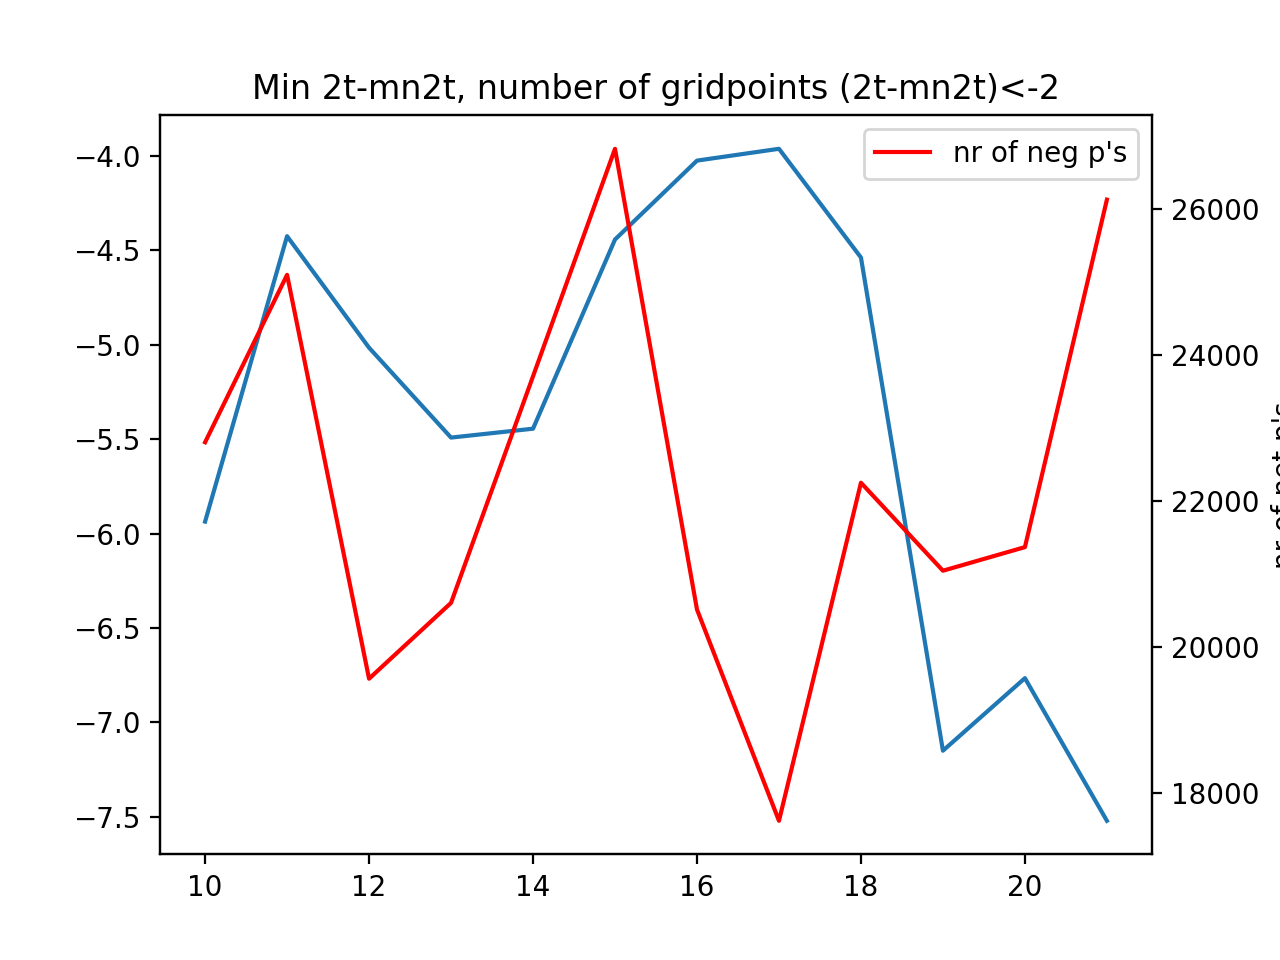

In [11]:
atemp=np.array(an2t_mn2t_diff[1])
fig, ax_1 = plt.subplots()
ax_2 = ax_1.twinx()
ax_2.set_ylabel("nr of net p's")
ax_1.plot(atemp[:,3],atemp[:,1])
ax_2.plot(atemp[:,3], atemp[:,2], c='r', label="nr of neg p's")
ax_2.legend()
plt.title("Min 2t-mn2t, number of gridpoints (2t-mn2t)<-2")
plt.show()

To have a more visual view, let's look at full data in one timestep

<IPython.core.display.Javascript object>


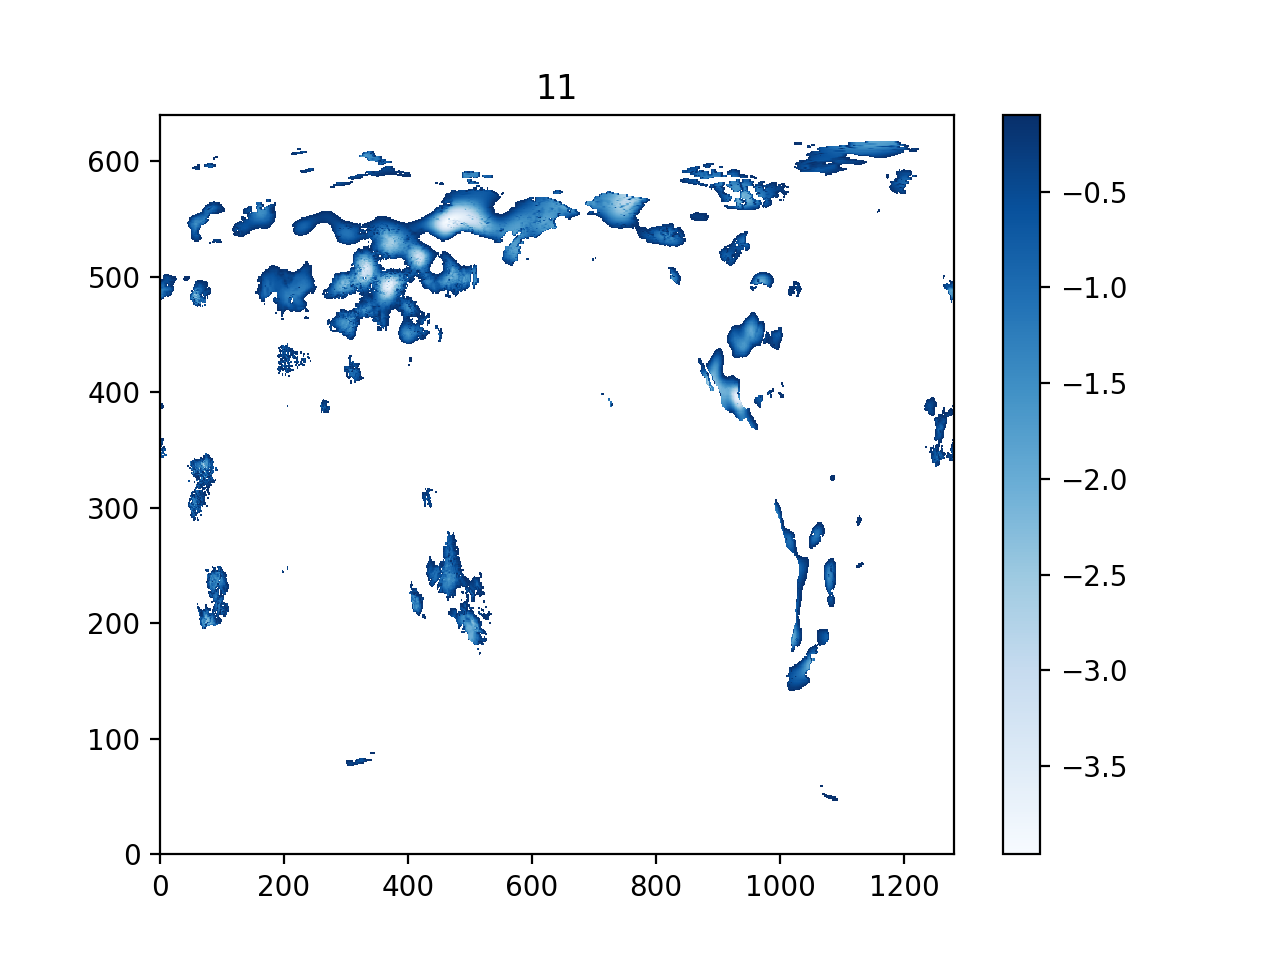

In [12]:
tstep = 10
tstep_min = tstep + 1 
anstep = tstep + 7
assert get_grib_time_step(ft2m_an[anstep])==get_grib_time_step(fmin[tstep]), "{0} {1}".format(get_grib_time_step(ft2m_an[anstep]), get_grib_time_step(fmin[tstep]))
fig=plt.figure()
td = np.flipud(ft2m_an[anstep].data()[0] - fmin[tstep_min].data()[0])
plt.pcolormesh(np.ma.masked_where(td > -0.1,td), cmap=plt.cm.Blues)
plt.colorbar()
plt.title(fmin[tstep+1].step)
plt.show()

Similar for 2t forecast vs mn2t

<IPython.core.display.Javascript object>


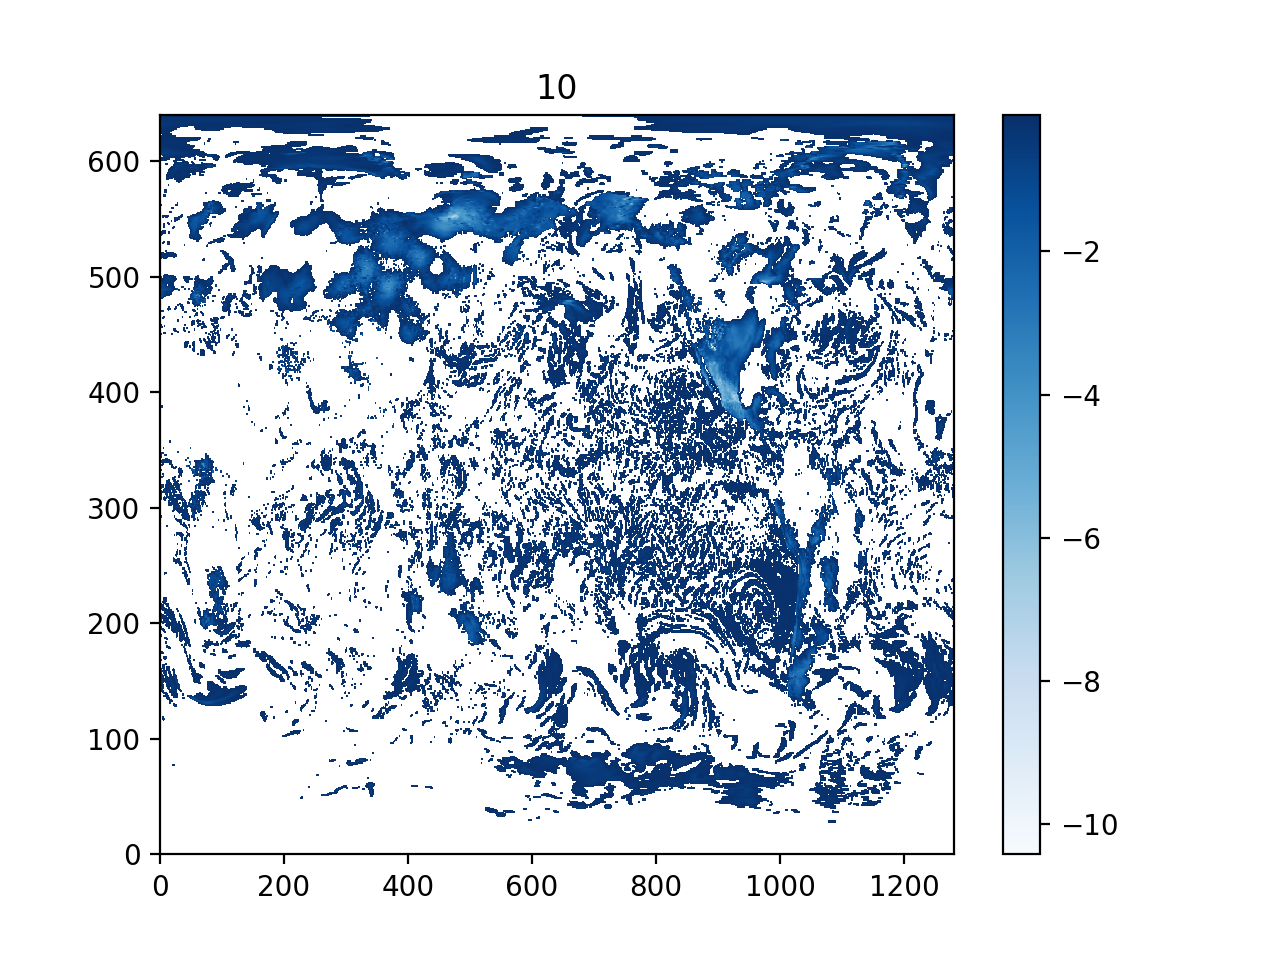

In [13]:
tstep = 10
tstep_min = tstep + 1
anstep = tstep + 7
assert get_grib_time_step(ft2m_an[anstep])==get_grib_time_step(ft2m[tstep]), "{0} {1}".format(get_grib_time_step(ft2m_an[anstep]), get_grib_time_step(ft2m[tstep]))
fig=plt.figure()
td = np.flipud(ft2m_an[anstep].data()[0] - ft2m[tstep_min].data()[0])
plt.pcolormesh(np.ma.masked_where(td > -0.1,td), cmap=plt.cm.Blues)
plt.colorbar()
plt.title(fmin[tstep].step)
plt.show()